Predicting the Behavior of the Supreme Court of the United States: A General Approach
==================
  *  __Title__: Predicting the Behavior of the Supreme Court of the United States: A General Approach
  *  __Authors__: [Daniel Martin Katz](http://www.law.msu.edu/faculty_staff/profile.php?prof=780), [Michael J Bommarito II](http://bommaritollc.com/), [Josh Blackman](http://joshblackman.com)
  *  __Paper URL__: [http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2463244](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2463244)
  *  __Blog URL__: [http://lexpredict.com/portfolio/predicting-the-supreme-court/](http://lexpredict.com/portfolio/predicting-the-supreme-court/)

## Paper Abstract
Building upon developments in theoretical and applied machine learning, as well as the efforts of various scholars including Guimera and Sales-Pardo (2011), Ruger et al. (2004), and Martin et al. (2004), we construct a model designed to predict the voting behavior of the Supreme Court of the United States. Using the extremely randomized tree method first proposed in Geurts, et al. (2006), a method similar to the random forest approach developed in Breiman (2001), as well as novel feature engineering, we predict more than sixty years of decisions by the Supreme Court of the United States (1953-2013). Using only data available prior to the date of decision, our model correctly identifies 69.7% of the Court’s overall affirm/reverse decisions and correctly forecasts 70.9% of the votes of individual justices across 7,700 cases and more than 68,000 justice votes. Our performance is consistent with the general level of prediction offered by prior scholars. However, our model is distinctive as it is the first robust, generalized,and fully predictive model of Supreme Court voting behavior offered to date. Our model predicts six decades of behavior of thirty Justices appointed by thirteen Presidents. With a more sound methodological foundation, our results represent a major advance for the science of quantitative legal prediction and portend a range of other potential applications, such as those described in Katz (2013).

## Source Description
The source and data in this repository allow for the reproduction of the results in this paper.  

## Data Description
The data used in this paper is available from the [Supreme Court Database (SCDB)](http://scdb.wustl.edu/).

## Version
The latest version of this model was relesed in October 2015.

In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from model import *

/home/ubuntu/ve/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Get raw data
raw_data = get_raw_scdb_data("data/input/SCDB_2015_01_justiceCentered_Citation.csv")

# Get feature data
feature_df = preprocess_raw_data(raw_data, include_direction=True)

In [3]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(77342, 82)
(77342, 1365)


In [4]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 1                        43951
 0                        26293
-1                         7098
    justice_outcome_disposition
 1                     0.568268
 0                     0.339958
-1                     0.091774


In [5]:
# Setup training time period
min_training_years = 5
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 100

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = raw_data.loc[train_index, "justice_outcome_disposition"].astype(int).values

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = raw_data.loc[test_index, "justice_outcome_disposition"].astype(int).values
    
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "justice"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "justice"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term), 
                                                    class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    n_jobs=-1)
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_data_train, target_data_train)
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)

Term: 1951
Term: 1952
Term: 1953
Natural court change; rebuilding with 800 trees
Term: 1954
Natural court change; rebuilding with 900 trees
Term: 1955
Term: 1956
Natural court change; rebuilding with 1100 trees
Term: 1957
Natural court change; rebuilding with 1200 trees
Term: 1958
Natural court change; rebuilding with 1300 trees
Term: 1959
Natural court change; rebuilding with 1400 trees
Term: 1960
Term: 1961
Natural court change; rebuilding with 1600 trees
Term: 1962
Natural court change; rebuilding with 1700 trees
Term: 1963
Term: 1964
Term: 1965
Natural court change; rebuilding with 2000 trees
Term: 1966
Term: 1967
Natural court change; rebuilding with 2200 trees
Term: 1968
Term: 1969
Natural court change; rebuilding with 2400 trees
Term: 1970
Term: 1971
Natural court change; rebuilding with 2600 trees
Term: 1972
Term: 1973
Term: 1974
Term: 1975
Natural court change; rebuilding with 3000 trees
Term: 1976
Natural court change; rebuilding with 3100 trees
Term: 1977
Term: 1978
Term: 19

/home/ubuntu/ve/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:487: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


In [6]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = raw_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"]
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.93      0.44      0.60      6700
          0       0.61      0.33      0.43     24325
          1       0.65      0.88      0.75     41142

avg / total       0.66      0.66      0.63     72167

[[ 2953   401  3346]
 [   86  8070 16169]
 [  148  4663 36331]]
0.656172488811

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      6700
          0       0.00      0.00      0.00     24325
          1       0.57      1.00      0.73     41142

avg / total       0.33      0.57      0.41     72167

[[    0     0  6700]
 [    0     0 24325]
 [    0     0 41142]]
0.57009436446



/home/ubuntu/ve/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


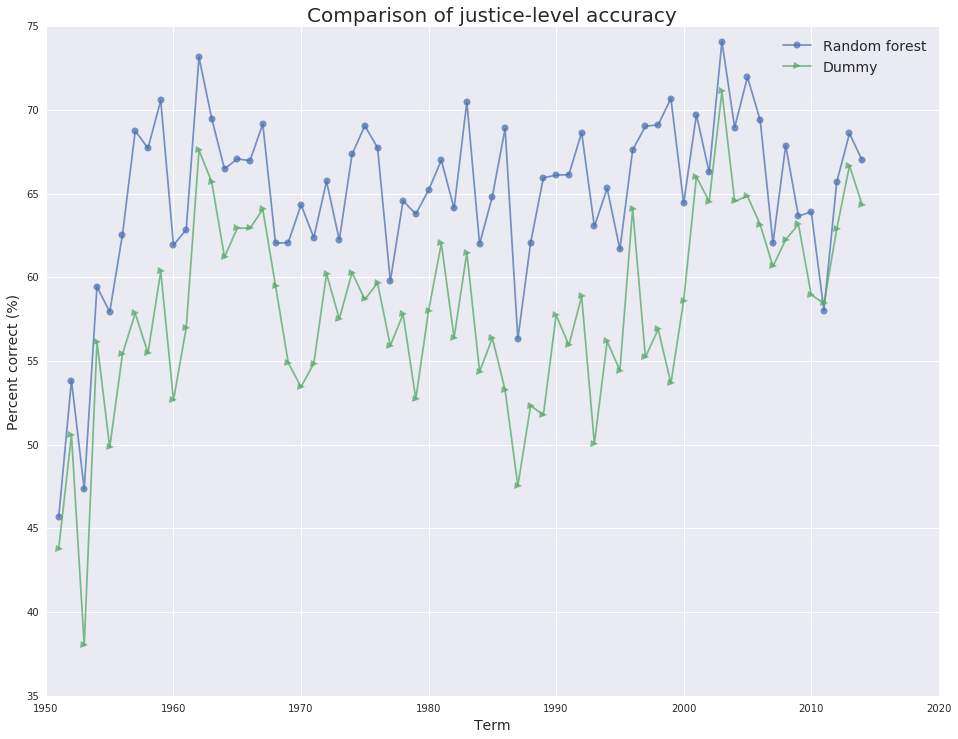

In [74]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts * 100,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts * 100,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'), fontsize=14)
plt.xlabel("Term", fontsize=14)
plt.ylabel("Percent correct (%)", fontsize=14)
plt.title("Comparison of justice-level accuracy", fontsize=20)
plt.savefig("figures/justice_accuracy_by_term_model_100.eps")
plt.savefig("figures/justice_accuracy_by_term_model_100.png")

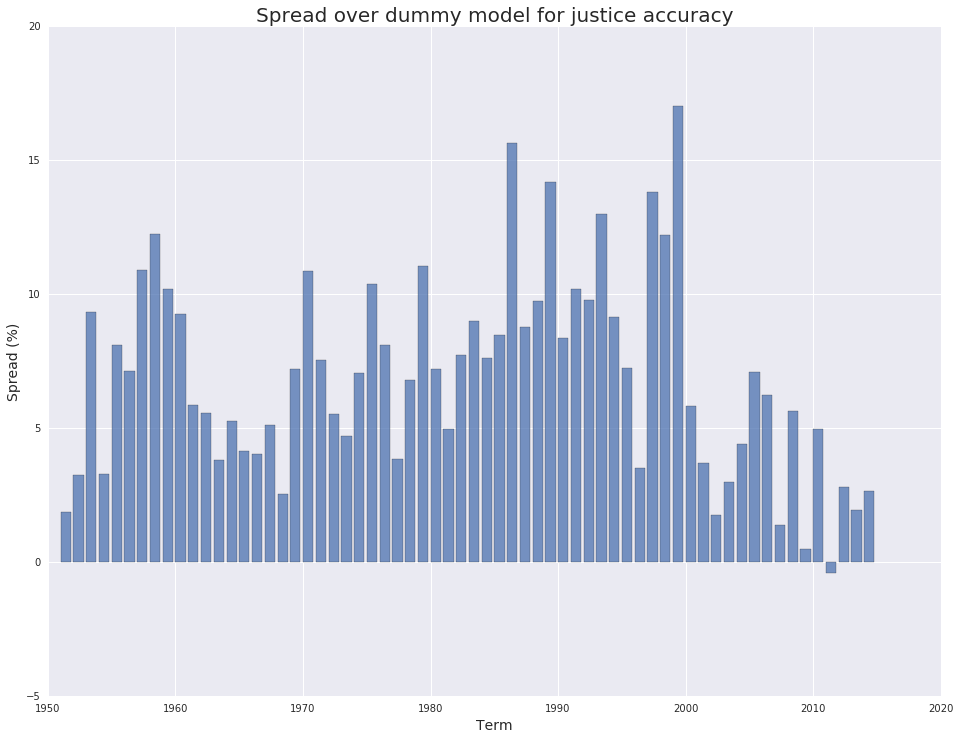

In [76]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts * 100,
        alpha=0.75)
plt.xlabel("Term", fontsize=14)
plt.ylabel("Spread (%)", fontsize=14)
plt.title("Spread over dummy model for justice accuracy", fontsize=20)
plt.savefig("figures/justice_accuracy_spread_by_term_model_100.eps")
plt.savefig("figures/justice_accuracy_spread_by_term_model_100.png")

In [9]:
# Feature importance
feature_importance_df = pandas.DataFrame(zip(feature_df.columns, m.feature_importances_),
                                         columns=["feature", "importance"])
feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
130,decision_delay,0.031439
1363,justice_previous_lc_direction_diff,0.026961
1364,justice_cumulative_lc_direction_diff,0.026758
1352,justice_cumulative_action,0.015561
1357,justice_previous_agreement,0.015427
1154,issue_area_9,0.015319
1351,justice_previous_action,0.015280
1358,justice_cumulative_agreement,0.015191
1349,justice_previous_court_direction_diff,0.014667
1345,justice_previous_direction,0.014609


In [78]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=14.744985403366465, pvalue=4.2402818701844387e-22)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=6.6050943275309395, pvalue=3.9726431415202051e-11)
Binomial:
5.11850287496e-11


## Case Outcomes

In [79]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [80]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].agg(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 1    5435
 0    2639
-1     433
Name: case_outcome_disposition, dtype: int64
 1    0.629707
 0    0.305758
-1    0.050168
Name: case_outcome_disposition, dtype: float64


In [81]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = raw_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted_case"]

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)
case_classification_data = raw_data.loc[evaluation_index, ["docketId", "term", 
                                                           "case_outcome_disposition", "rf_predicted_case", "dummy_predicted_case",
                                                           "rf_correct_case", "dummy_correct_case"]
                                                          ].copy().drop_duplicates()

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(case_classification_data["case_outcome_disposition"],
                                            case_classification_data["rf_predicted_case"]))
print(sklearn.metrics.confusion_matrix(case_classification_data["case_outcome_disposition"],
                                            case_classification_data["rf_predicted_case"]))
print(sklearn.metrics.accuracy_score(case_classification_data["case_outcome_disposition"],
                                            case_classification_data["rf_predicted_case"]))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(case_classification_data["case_outcome_disposition"],
                                            case_classification_data["dummy_predicted_case"]))
print(sklearn.metrics.confusion_matrix(case_classification_data["case_outcome_disposition"],
                                            case_classification_data["dummy_predicted_case"]))
print(sklearn.metrics.accuracy_score(case_classification_data["case_outcome_disposition"],
                                            case_classification_data["dummy_predicted_case"]))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.91      0.50      0.65       412
        0.0       0.54      0.20      0.29      2410
        1.0       0.69      0.92      0.79      5110

avg / total       0.66      0.68      0.63      7932

[[ 208    9  195]
 [   7  472 1931]
 [  14  392 4704]]
0.678769541099

Dummy model
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00       412
        0.0       0.00      0.00      0.00      2410
        1.0       0.64      1.00      0.78      5110

avg / total       0.42      0.64      0.50      7932

[[   0    0  412]
 [   0    0 2410]
 [   0    0 5110]]
0.644225920323



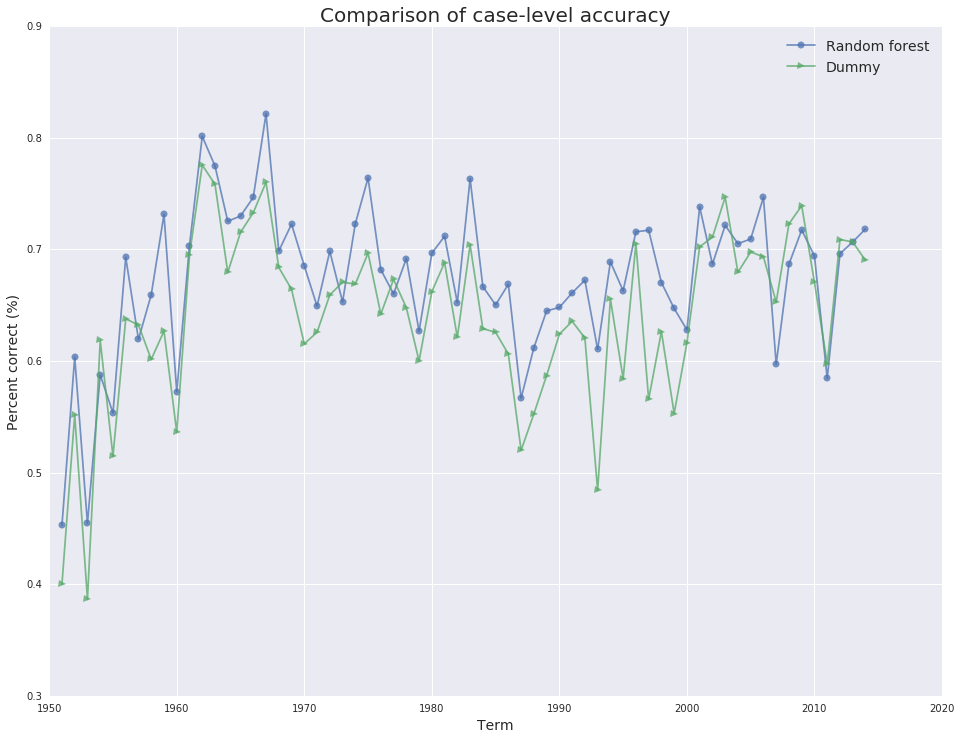

In [82]:
# Setup time series
rf_correct_case_ts = case_classification_data.groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = case_classification_data.groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts * 100,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts * 100,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'), fontsize=14)
plt.xlabel("Term", fontsize=14)
plt.ylabel("Percent correct (%)", fontsize=14)
plt.title("Comparison of case-level accuracy", fontsize=20)
plt.savefig("figures/case_accuracy_by_term_model_100.eps")
plt.savefig("figures/case_accuracy_by_term_model_100.png")

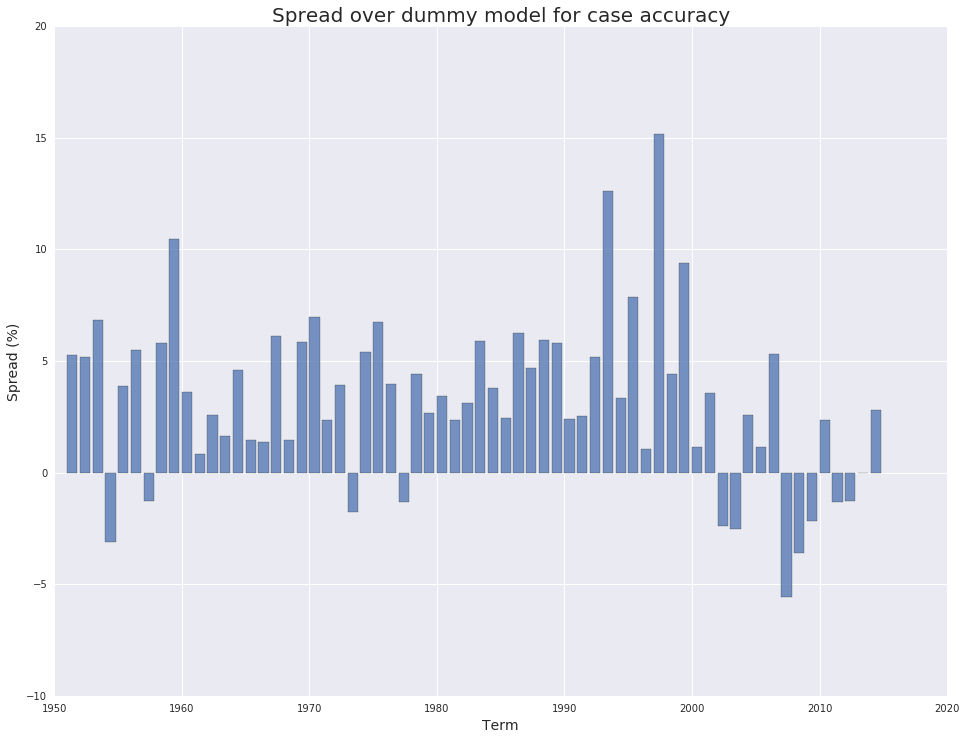

In [83]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts * 100,
        alpha=0.75)
plt.xlabel("Term", fontsize=14)
plt.ylabel("Spread (%)", fontsize=14)
plt.title("Spread over dummy model for case accuracy", fontsize=20)
plt.savefig("figures/case_accuracy_spread_by_term_model_100.eps")
plt.savefig("figures/case_accuracy_spread_by_term_model_100.png")

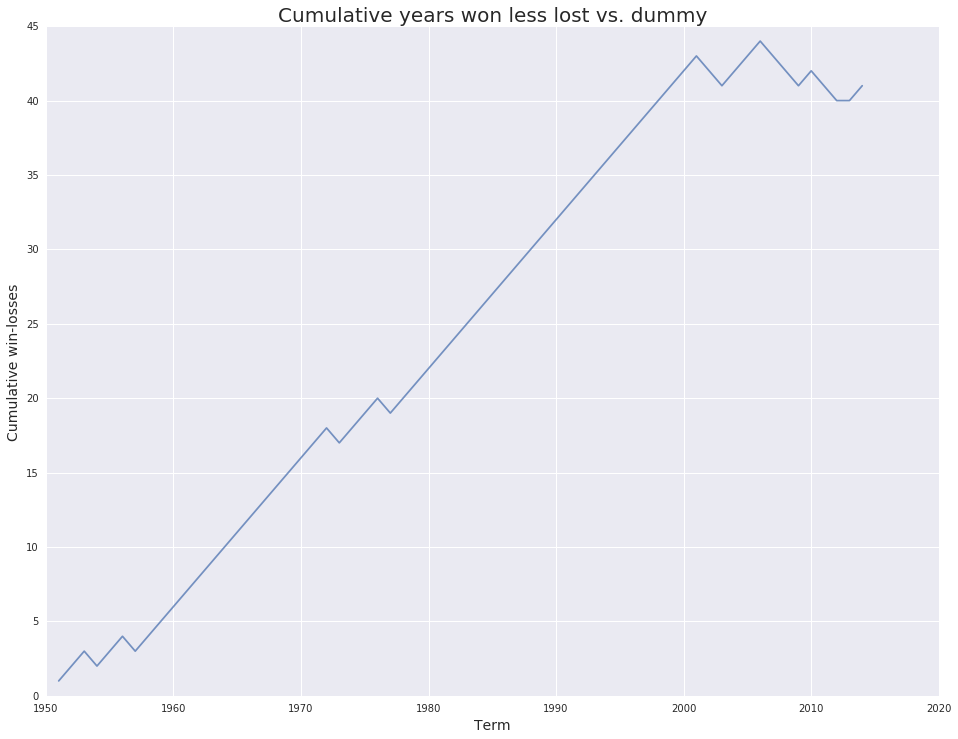

In [85]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)
plt.xlabel("Term", fontsize=14)
plt.ylabel("Cumulative win-losses", fontsize=14)
plt.title("Cumulative years won less lost vs. dummy", fontsize=20)
plt.savefig("figures/winloss_by_term_model_100.eps")
plt.savefig("figures/winloss_by_term_model_100.png")

In [86]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(case_classification_data["rf_correct_case"].sum(),
                                              case_classification_data["rf_correct_case"].shape[0],
                                              case_classification_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=6.9944861323963687, pvalue=2.0432030540867725e-09)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.5996240661386203, pvalue=0.0093325936360082531)
Binomial:
5.11850287496e-11


In [18]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,22281,22282,22283,22284,22285,22286,22287,22288,22289
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,1,1,1,1
rf_predicted_score_affirm,0.564142,0.232568,0.1495,0.56893,0.328381,0.481451,0.193381,0.4565,0.326616
rf_predicted_score_reverse,0.420358,0.730432,0.8275,0.42057,0.641619,0.488549,0.740119,0.5275,0.596884
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [19]:
raw_data.loc[raw_data.loc[:, "caseName"] == "OBERGEFELL v. HODGES", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,77288,77289,77290,77291,77292,77293,77294,77295,77296
caseName,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES,OBERGEFELL v. HODGES
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,0,1,0,1,1,0,1,1
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.274783,0.317246,0.267536,0.348116,0.26913,0.272029,0.309565,0.266377,0.25029
rf_predicted_score_reverse,0.698116,0.667246,0.712174,0.636522,0.713623,0.711739,0.672174,0.718116,0.732609
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [20]:
raw_data.loc[raw_data.loc[:, "caseName"] == "KING v. BURWELL", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,77126,77127,77128,77129,77130,77131,77132,77133,77134
caseName,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL,KING v. BURWELL
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,0,1,0,1,0,0,1,0,0
rf_predicted,0,1,1,1,0,0,1,0,0
rf_predicted_score_affirm,0.490103,0.487349,0.482801,0.480881,0.572641,0.571395,0.479399,0.594505,0.557279
rf_predicted_score_reverse,0.483086,0.497289,0.497054,0.503466,0.408808,0.412518,0.504804,0.389843,0.425185
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [21]:
raw_data.loc[raw_data.loc[:, "caseName"] == 'CITIZENS UNITED v. FEDERAL ELECTION COMMISSION',
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,73130,73131,73132,73133,73134,73135,73136,73137,73138
caseName,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION
justiceName,JGRoberts,JPStevens,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,1,0,1,1,1,0,0,1,0
rf_predicted,1,0,1,1,1,0,0,1,1
rf_predicted_score_affirm,0.297441,0.57875,0.270878,0.299844,0.271503,0.568906,0.517656,0.294472,0.323281
rf_predicted_score_reverse,0.67584,0.387656,0.708028,0.666719,0.705215,0.401562,0.452031,0.68334,0.492969
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [22]:
raw_data.loc[raw_data.loc[:, "caseName"] == 'DISTRICT OF COLUMBIA v. HELLER',
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,72257,72258,72259,72260,72261,72262,72263,72264,72265
caseName,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER,DISTRICT OF COLUMBIA v. HELLER
justiceName,JPStevens,AScalia,AMKennedy,DHSouter,CThomas,RBGinsburg,SGBreyer,JGRoberts,SAAlito
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,1,0,0,1,0,1,1,0,0
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.354032,0.392419,0.302258,0.34129,0.415645,0.362097,0.339677,0.345161,0.370484
rf_predicted_score_reverse,0.619677,0.586129,0.665968,0.635323,0.563226,0.616452,0.635806,0.619839,0.603065
rf_correct_case,0,0,0,0,0,0,0,0,0
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [23]:
# Write output
import cPickle as pickle
import time

timestamp_suffix = time.strftime("%Y%m%d%H%M%S")
raw_data.to_csv("data/output/model_output_{0}_{1}.csv".format(trees_per_term, timestamp_suffix),
                 index=False)
# You probably don't want to do this, as the object can be tens of GB
#pickle.dump(m, open("scotus_scdb_model_{0}.pickle".format(timestamp_suffix), "w"))